# Applied example: RTC time series analysis


Now that we have done so much work to organize these two datasets and prepare them for analysis, let's explore the data with a scientific question in mind.

In this example, we have data over a specific area of interest covering two glaciers and two proglacial lakes in the Central Himalaya near the India-Chinese border. As a glaciologist, I might be interested in questions related to the conditions of these surface -- is there a seasonal pattern to proglacial lake conditions? Do they freeze during the winter, and if so, at similar times? What is the surface of the glacier like at certain times of year? SAR backscatter imagery may not conclusively answer any of these questions in itself, but it can provide important insights about surface conditions and how they change over time that could be used to answer some of these questions.

This notebook will walk through some initial steps of how you could use the data objects we've created to explore backscatter dynamics over time and space for the area of interest we have identified. 

### Other useful resources
These are resources that contain additional examples and discussion of the content in this notebook and more.
- [Xarray user guide](https://docs.xarray.dev/en/stable/user-guide/index.html)
- [How do I...](https://docs.xarray.dev/en/stable/howdoi.html) this is **very** helpful!
- [Xarray High-level computational patterns](https://tutorial.xarray.dev/intermediate/01-high-level-computation-patterns.html) discussion of concepts and associated code examples
- [Parallel computing with dask](https://tutorial.xarray.dev/intermediate/xarray_and_dask.html) Xarray tutorial demonstrating wrapping of dask arrays

## Software and setup

In [ ]:
import geopandas as gpd
import xarray as xr
from s1_tools import power_to_db, get_bbox_single
from shapely import geometry
import matplotlib.pyplot as plt
import numpy as np

### Utility functions

In [ ]:
def get_bbox_single(input_xr, buffer = 0):
    
    '''Takes input xr object (from itslive data cube), plots a quick map of the footprint. 
    currently only working for granules in crs epsg 32645'''

    xmin = input_xr.coords['x'].data.min()
    xmax = input_xr.coords['x'].data.max()

    ymin = input_xr.coords['y'].data.min()
    ymax = input_xr.coords['y'].data.max()

    pts_ls = [(xmin, ymin), (xmax, ymin),(xmax, ymax), (xmin, ymax), (xmin, ymin)]
 
    crs = input_xr.rio.crs

    polygon_geom = geometry.Polygon(pts_ls)
    polygon = gpd.GeoDataFrame(index=[0], crs=crs, geometry=[polygon_geom]) 
    polygon_prj = polygon
    polygon = polygon_prj.to_crs(crs)

    #add a buffer if needed
    bounds = polygon.total_bounds
    #bounds = [bounds[0]-500, bounds[2]+500, bounds[1]-500, bounds[3]+500]
    
    bounds_xmin = bounds[0]-buffer
    bounds_xmax = bounds[2]+buffer
    bounds_ymin = bounds[1]-buffer
    bounds_ymax = bounds[3]+buffer
    
    bounds_ls = [(bounds_xmin, bounds_ymin), (bounds_xmax, bounds_ymin),
                 (bounds_xmax, bounds_ymax), (bounds_xmin, bounds_ymax),
                 (bounds_xmin, bounds_ymin)]
                   
    
    bounds_geom = geometry.Polygon(bounds_ls)
    bound_gdf = gpd.GeoDataFrame(index=[0], crs=crs, geometry = [bounds_geom])
    bounds_prj = bound_gdf.to_crs(crs)
    
    return bounds_prj

In [ ]:
def power_to_db(input_arr):
    return (10*np.log10(np.abs(input_arr)))


### Read in prepared RTC data

- this example will use ASF dataset

In [ ]:
%store -r vrt_full

In [ ]:
vrt_full

<xarray.Dataset>
Dimensions:                           (acq_date: 103, y: 396, x: 290)
Coordinates: (12/17)
  * acq_date                          (acq_date) datetime64[ns] 2021-05-02T12...
  * x                                 (x) float64 6.194e+05 ... 6.281e+05
  * y                                 (y) float64 3.102e+06 ... 3.09e+06
    spatial_ref                       int64 0
    sensor                            (acq_date) <U3 'S1A' 'S1A' ... 'S1A' 'S1A'
    beam_mode                         (acq_date) <U2 'IW' 'IW' ... 'IW' 'IW'
    ...                                ...
    masked                            (acq_date) <U1 'u' 'u' 'u' ... 'u' 'u' 'u'
    filtered                          (acq_date) <U1 'n' 'n' 'n' ... 'n' 'n' 'n'
    area                              (acq_date) <U1 'e' 'e' 'e' ... 'e' 'e' 'e'
    product_id                        (acq_date) <U4 '748F' '0D1E' ... 'BD36'
    granule_id                        (acq_date) <U67 'S1A_IW_SLC__1SDV_20210...
    orbital_dir                       (acq_date) <U4 'desc' 'asc' ... 'desc'
Data variables:
    vv                                (acq_date, y, x) float32 dask.array<chunksize=(1, 396, 290), meta=np.ndarray>
    vh                                (acq_date, y, x) float32 dask.array<chunksize=(1, 396, 290), meta=np.ndarray>
    ls                                (acq_date, y, x) float64 dask.array<chunksize=(1, 396, 290), meta=np.ndarray>

In [ ]:
vrt_full =  vrt_full.where(vrt_full.vv != 0., np.nan, drop=False)

### Read in vector data 

- Manually-drawn outlines of proglacial lakes

In [ ]:
lakes = gpd.read_file('https://github.com/e-marshall/sentinel1_rtc/raw/main/proglacial_lake_outline.geojson')
lakes_prj = lakes.to_crs('EPSG:32645')
lakes_prj

,id,geometry
0,1,"POLYGON ((623555.903 3099600.816, 623594.809 3..."
1,2,"POLYGON ((622405.254 3097521.050, 622268.598 3..."


Glacier outlines from Randolph Glacier Inventory

In [ ]:
da_bbox = get_bbox_single(vrt_full)

In [ ]:
rgi = gpd.read_file('https://github.com/e-marshall/itslive/raw/master/rgi15_southasiaeast.geojson')
rgi.head(3)
rgi_prj = rgi.to_crs('epsg:32645')

rgi_sub = gpd.sjoin(rgi_prj, da_bbox, how='inner')

In [ ]:
rgi_sub.explore()

In [ ]:
rgi_sub

,RGIId,GLIMSId,BgnDate,EndDate,CenLon,CenLat,O1Region,O2Region,Area,Zmin,...,Lmax,Status,Connect,Form,TermType,Surging,Linkages,Name,geometry,index_right
2912,RGI60-15.02913,G088261E27938N,20001108,-9999999,88.260530,27.937820,15,2,0.222,5278,...,667,0,0,0,0,9,9,None,"POLYGON ((624154.597 3091139.237, 624154.597 3...",0
2913,RGI60-15.02914,G088296E27928N,20001108,-9999999,88.296067,27.928288,15,2,0.248,5372,...,524,0,0,0,0,9,9,None,"POLYGON ((627398.396 3089890.401, 627403.687 3...",0
2915,RGI60-15.02916,G088280E27949N,20001108,-9999999,88.279920,27.949292,15,2,0.166,5325,...,589,0,0,0,0,9,9,None,"POLYGON ((626107.884 3092444.923, 626110.594 3...",0
2916,RGI60-15.02917,G088289E27956N,20001108,-9999999,88.288797,27.955961,15,2,0.461,5351,...,843,0,0,0,0,9,9,None,"POLYGON ((626663.114 3092564.217, 626654.813 3...",0
2917,RGI60-15.02918,G088285E27952N,20001108,-9999999,88.284713,27.951895,15,2,0.169,5354,...,682,0,0,0,0,9,9,None,"POLYGON ((626491.921 3092669.295, 626516.842 3...",0
2918,RGI60-15.02919,G088277E27950N,20001108,-9999999,88.276515,27.950028,15,2,0.133,5403,...,372,0,0,0,0,9,9,None,"POLYGON ((625706.190 3092218.712, 625675.749 3...",0
2919,RGI60-15.02920,G088283E27949N,20001108,-9999999,88.282704,27.948794,15,2,0.052,5436,...,456,0,0,0,0,9,9,None,"POLYGON ((626202.575 3092388.557, 626217.905 3...",0
10460,RGI60-15.10461,G088226E27972N,20100128,-9999999,88.226000,27.972000,15,2,1.949,5410,...,2435,0,0,0,0,9,9,CN5O197B0032,"POLYGON ((620316.436 3095795.468, 620337.845 3...",0
10461,RGI60-15.10462,G088239E27978N,20100128,-9999999,88.239000,27.978000,15,2,0.495,5654,...,1807,0,0,0,0,9,9,CN5O197B0031,"POLYGON ((621679.118 3094643.491, 621669.750 3...",0
10462,RGI60-15.10463,G088251E27968N,20100128,-9999999,88.251000,27.968000,15,2,6.924,5335,...,6668,0,0,0,0,9,9,CN5O197B0030,"POLYGON ((624579.834 3093180.112, 624573.058 3...",0


In [ ]:
rgi_sub = rgi_sub.loc[rgi_sub['RGIId'].isin(['RGI60-15.10463','RGI60-15.10464'])]

In [ ]:
rgi_sub

,RGIId,GLIMSId,BgnDate,EndDate,CenLon,CenLat,O1Region,O2Region,Area,Zmin,...,Lmax,Status,Connect,Form,TermType,Surging,Linkages,Name,geometry,index_right
10462,RGI60-15.10463,G088251E27968N,20100128,-9999999,88.251,27.968,15,2,6.924,5335,...,6668,0,0,0,0,9,9,CN5O197B0030,"POLYGON ((624579.834 3093180.112, 624573.058 3...",0
10463,RGI60-15.10464,G088271E27976N,20100128,-9999999,88.271,27.976,15,2,5.319,5328,...,5609,0,0,0,0,9,9,CN5O197B0029 Chutanjima Glacier,"POLYGON ((626179.758 3095289.794, 626190.220 3...",0


Text(0.5, 0.98, 'ASF RTC backscatter image, 30 Apr 2022')

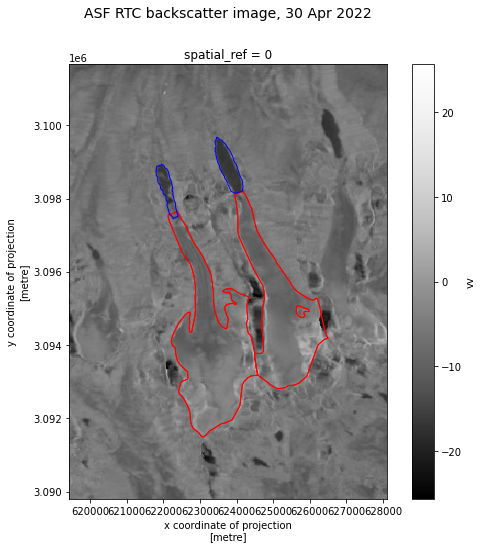

In [ ]:
fig, ax = plt.subplots(figsize=(9,8))

power_to_db(vrt_full.vv.mean(dim=['acq_date'])).plot(ax=ax, cmap=plt.cm.Greys_r)

rgi_sub.plot(edgecolor='r', facecolor='none', ax=ax)
rgi_sub.plot(edgecolor='r', facecolor='none', ax=ax)

lakes_prj.plot(ax=ax, facecolor='none', edgecolor='blue')

fig.suptitle('ASF RTC backscatter image, 30 Apr 2022', fontsize=14);


## Clip to lake extent

In [ ]:
lake1 = lakes_prj.loc[lakes_prj['id']== 1]
lake2 = lakes_prj.loc[lakes_prj['id'] == 2]

In [ ]:
lake1_asf = vrt_full.rio.clip(lake1.geometry, lake1.crs)
lake2_asf = vrt_full.rio.clip(lake2.geometry, lake2.crs)

In [ ]:
lake1_asf

<xarray.Dataset>
Dimensions:                           (acq_date: 103, x: 26, y: 51)
Coordinates: (12/17)
  * acq_date                          (acq_date) datetime64[ns] 2021-05-02T12...
  * x                                 (x) float64 6.234e+05 ... 6.242e+05
  * y                                 (y) float64 3.1e+06 3.1e+06 ... 3.098e+06
    sensor                            (acq_date) <U3 'S1A' 'S1A' ... 'S1A' 'S1A'
    beam_mode                         (acq_date) <U2 'IW' 'IW' ... 'IW' 'IW'
    polarisation_type                 (acq_date) <U2 'DV' 'DV' ... 'DV' 'DV'
    ...                                ...
    filtered                          (acq_date) <U1 'n' 'n' 'n' ... 'n' 'n' 'n'
    area                              (acq_date) <U1 'e' 'e' 'e' ... 'e' 'e' 'e'
    product_id                        (acq_date) <U4 '748F' '0D1E' ... 'BD36'
    granule_id                        (acq_date) <U67 'S1A_IW_SLC__1SDV_20210...
    orbital_dir                       (acq_date) <U4 'desc' 'asc' ... 'desc'
    spatial_ref                       int64 0
Data variables:
    vv                                (acq_date, y, x) float32 dask.array<chunksize=(1, 51, 26), meta=np.ndarray>
    vh                                (acq_date, y, x) float32 dask.array<chunksize=(1, 51, 26), meta=np.ndarray>
    ls                                (acq_date, y, x) float64 dask.array<chunksize=(1, 51, 26), meta=np.ndarray>

In [ ]:
lakes_prj['color'] = ['r','b']
lakes_prj

,id,geometry,color
0,1,"POLYGON ((623555.903 3099600.816, 623594.809 3...",r
1,2,"POLYGON ((622405.254 3097521.050, 622268.598 3...",b


/home/emmamarshall/miniconda3/envs/sentinel/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in log10
  return func(*(_execute_task(a, cache) for a in args))
/home/emmamarshall/miniconda3/envs/sentinel/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in log10
  return func(*(_execute_task(a, cache) for a in args))
/home/emmamarshall/miniconda3/envs/sentinel/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in log10
  return func(*(_execute_task(a, cache) for a in args))
/home/emmamarshall/miniconda3/envs/sentinel/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in log10
  return func(*(_execute_task(a, cache) for a in args))


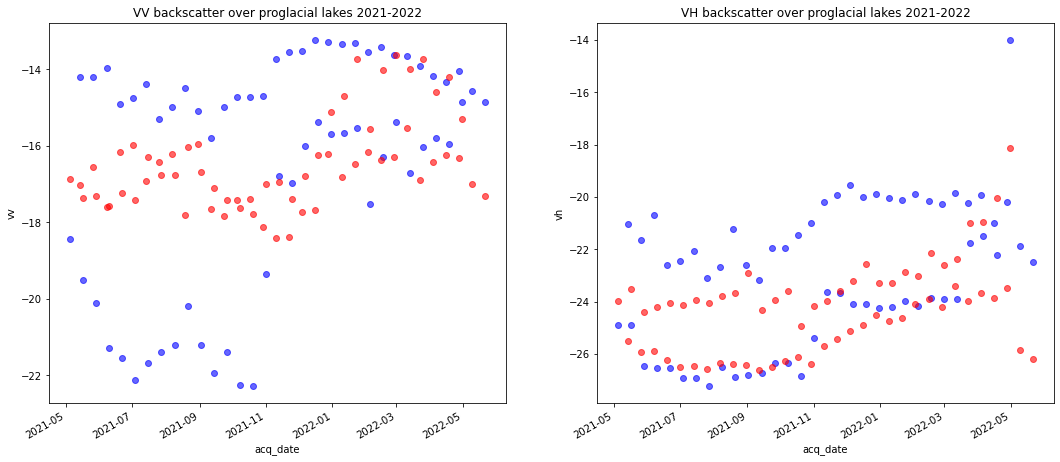

In [ ]:
from matplotlib.lines import Line2D

fig, axs = plt.subplots(ncols = 2, figsize=(18,7))

#scatter plot VV
power_to_db(lake2_asf.vv.mean(dim=['x','y'])).plot(ax=axs[0], color = 'blue', marker='o', linewidth=0, alpha = 0.6);
power_to_db(lake1_asf.vv.mean(dim=['x','y'])).plot(ax=axs[0], color = 'red', marker = 'o', linewidth = 0, alpha = 0.6);

#scatter plot VH
power_to_db(lake2_asf.vh.mean(dim=['x','y'])).plot(ax=axs[1], color = 'blue', marker='o', linewidth=0, alpha = 0.6);
power_to_db(lake1_asf.vh.mean(dim=['x','y'])).plot(ax=axs[1], color = 'red', marker = 'o', linewidth = 0, alpha = 0.6);


axs[0].set_title('VV backscatter over proglacial lakes 2021-2022')
axs[1].set_title('VH backscatter over proglacial lakes 2021-2022')

legend_elements = [Line2D([0], [0], color = 'r', lw = 3, label = 'lake 1'),
                   Line2D([0], [0], color = 'b', lw = 3, label = 'lake 2')]  ;           

What observations can we make about VV and VH variability in the above plots? What would we want to look at next to further explore those observations? 